# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas as pd # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

In [2]:
data = pd.read_csv("sealevel.csv")

In [3]:
data.head()

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed,Non GIS smooth cycle removed
0,0,11,1993.011526,452600,327401.31,-38.61,89.88,-38.78,-38.61,89.88,-38.78,-38.56,-38.57
1,0,12,1993.038692,447591,324498.41,-42.01,90.93,-39.80,-42.00,90.93,-39.80,-39.09,-39.10
2,0,13,1993.065858,459462,333018.19,-41.97,87.31,-39.65,-41.96,87.31,-39.64,-38.56,-38.58
3,0,14,1993.093025,410064,297483.19,-42.71,90.79,-39.69,-42.69,90.79,-39.67,-38.32,-38.35
4,0,15,1993.120191,446813,321635.81,-37.88,90.29,-38.78,-37.85,90.29,-38.75,-37.20,-37.24


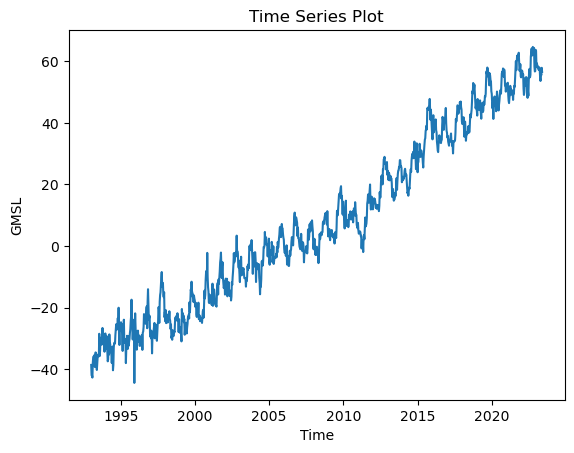

In [4]:
import matplotlib.pyplot as plt
plt.plot(data["Year"], data["GMSL"], linestyle='-')
plt.xlabel('Time') 
plt.ylabel('GMSL')  
plt.title('Time Series Plot') 
plt.show()

In [5]:
data.shape[0]

1119

There are 1119 observations in the given data

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** The main assumption in an AR model is time series is stationary, having a upward trend in the data violates this assumption. Fitting an AR model the data with this trend can lead to inaccurate results. By removing the trend we can also allow AR model to capture the temporal dependencies.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

In [6]:
#Extracting input and output variables
u_t = data['Year'].values.reshape(-1, 1)  # Converting to a 2D array
y_t = data['GMSL'].values

In [7]:
#fitting a linear regression model
linreg = lm.LinearRegression().fit(u_t, y_t)

In [8]:
#parameters of linear regression model
theta0 = linreg.intercept_
theta1 = linreg.coef_[0]
print("theta0:",theta0)
print("theta1:",theta1)

theta0: -6385.358282332333
theta1: 3.1835977252943026


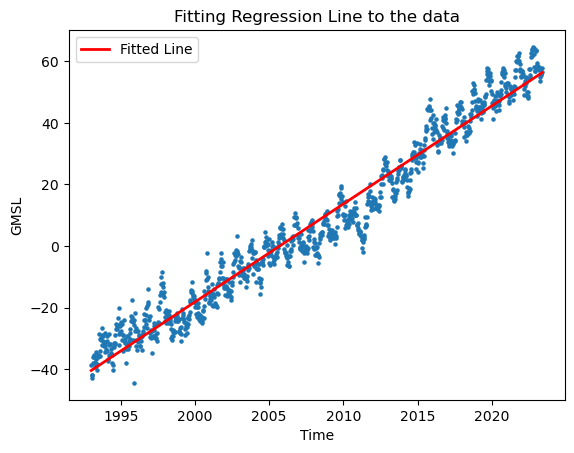

In [9]:
# plotting fitted regression line to the data
plt.scatter(data["Year"], data["GMSL"], marker="o", s=5)
plt.plot(u_t, linreg.predict(u_t), label='Fitted Line', color='red', linewidth=2)
plt.xlabel('Time') 
plt.ylabel('GMSL')  
plt.title('Fitting Regression Line to the data') 
plt.legend()
plt.show()

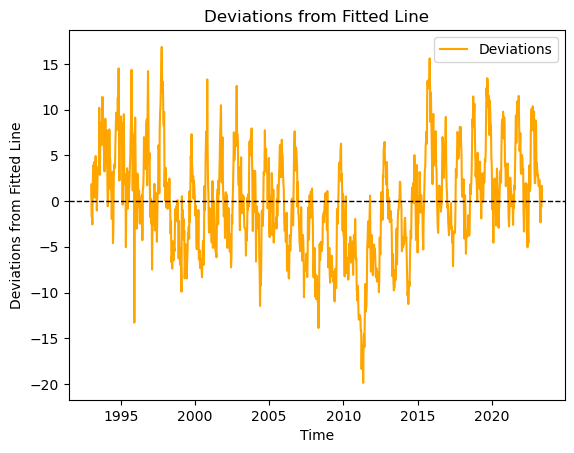

In [10]:
# plotting deviations 
deviations = y_t - linreg.predict(u_t)
plt.plot(data['Year'], deviations, label='Deviations', color='orange')
plt.xlabel('Time')
plt.ylabel('Deviations from Fitted Line')
plt.title('Deviations from Fitted Line')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0 for reference
plt.legend()
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

In [11]:
temp_data_year = data['Year'].values
new_data = pd.DataFrame({'Year': temp_data_year, 'deviations': deviations})

#changing column name of "deviations" to "GMSL"
new_data = new_data.rename(columns={'deviations': 'GMSL'})

# splitting into training and validation
train = new_data[0:700]
valid = new_data[701:]

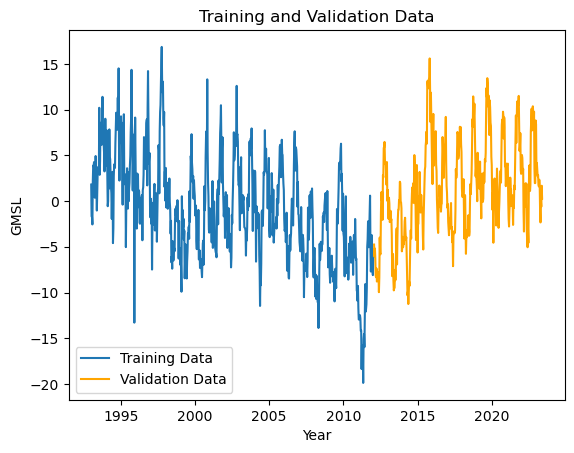

In [12]:
# Plot the training data
plt.plot(train['Year'], train['GMSL'], label='Training Data')

# Plot the validation data 
plt.plot(valid['Year'], valid['GMSL'], label='Validation Data', color='orange')

plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Training and Validation Data')
plt.legend()

# Show the plot
plt.show()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [13]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p))  # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[j:n-p+j] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [14]:
ar_coeff = fit_ar(train['GMSL'].values, p=10)
print("AR Coefficients for p =", 10, ":", ar_coeff)

AR Coefficients for p = 10 : [ 0.0251526  -0.0893176   0.0479181  -0.05693816 -0.07140349 -0.02284342
  0.17683292  0.12558768  0.1231388   0.63068183]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [50]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        # <COMPLETE THIS CODE BLOCK>
        y_pred[i] = np.dot(theta,y_target[i:p+i]) # <COMPLETE THIS LINE>
        
    return y_pred

In [51]:
# Using the AR coefficients (ar_coeff) to make predictions for the training and validation data.
train_pred = predict_ar_1step(ar_coeff,train["GMSL"])
valid_pred = predict_ar_1step(ar_coeff,valid["GMSL"])

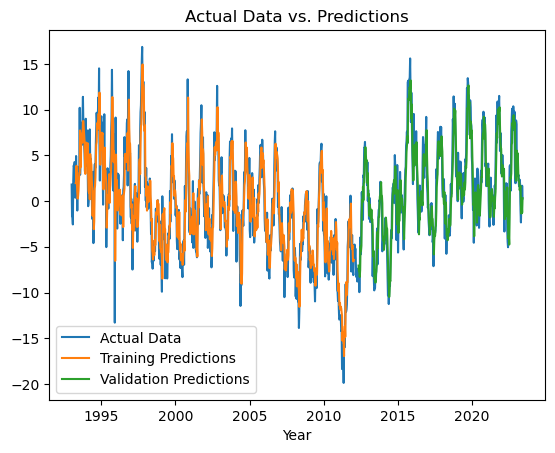

In [52]:
# plotting the actual data (training and validation)
plt.plot(new_data["Year"], new_data["GMSL"], label="Actual Data")

# plotting training predictions
plt.plot(train["Year"][10:], train_pred, label="Training Predictions")

# plotting validation predictions
plt.plot(valid["Year"][10:], valid_pred, label="Validation Predictions")

plt.title("Actual Data vs. Predictions")
plt.xlabel("Year")
plt.legend()
plt.show()

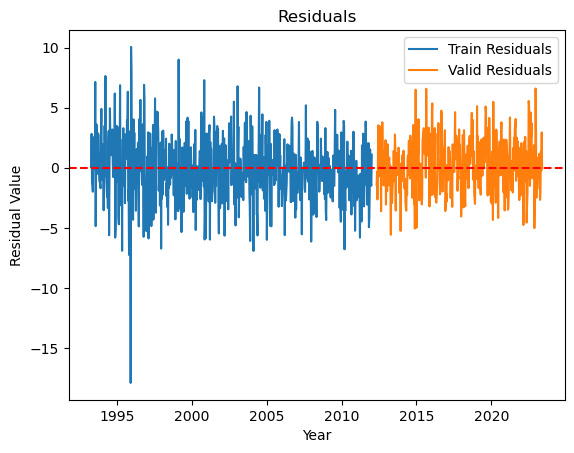

In [53]:
# residuals for training data
residuals_train = train["GMSL"].values[10:] - train_pred

# residuals for validation data
residuals_valid = valid["GMSL"].values[10:] - valid_pred

# plotting residuals
plt.plot(train["Year"].values[10:], residuals_train, label="Train Residuals")
plt.plot(valid["Year"].values[10:], residuals_valid, label="Valid Residuals")
plt.title("Residuals")
plt.xlabel("Year")
plt.ylabel("Residual Value")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

In [19]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



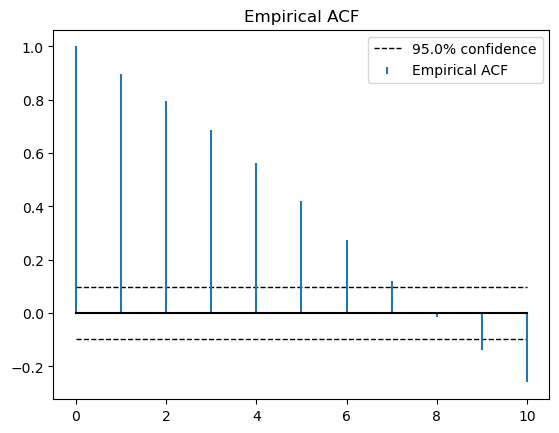

In [46]:
acfplot(x=residuals_valid,lags=10,conf=0.95)

##### Observation: 
From the above ACF plot, we can say that the first regression coefficient (lag-1) has more impact on the data because it has a high autocorrelation value. However, the autocorrelation values for other coefficients are within a normal range, they contribute less influence on the data. This suggests that the first coefficient is the most important in explaining the data's patterns.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [47]:
p = range(2,150+1)
train_mse = np.zeros(len(p))
valid_mse = np.zeros(len(p))
for i in p:
    ar_coef = fit_ar(train['GMSL'].values, p=i)
    pred_train = predict_ar_1step(ar_coef,train["GMSL"])
    pred_valid = predict_ar_1step(ar_coef,valid["GMSL"])
    train_mse[i-2]=np.mean(((pred_train - train["GMSL"][i:]) ** 2))
    valid_mse[i-2]= np.mean(((pred_valid - valid["GMSL"][i:]) ** 2))

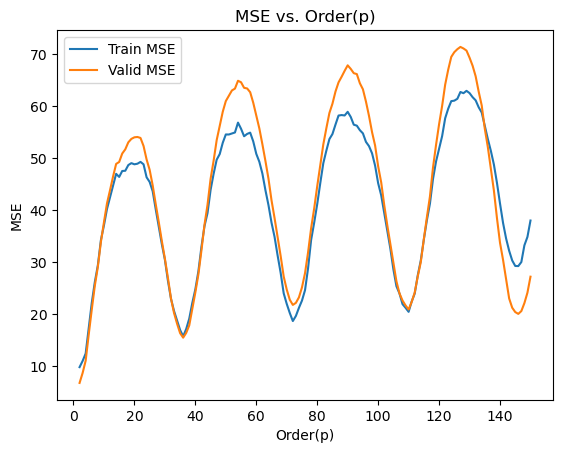

In [48]:
plt.plot(p,train_mse, label="Train MSE")
plt.plot(p,valid_mse, label="Valid MSE")
plt.title("MSE vs. Order(p)")
plt.xlabel("Order(p)")
plt.ylabel("MSE")
plt.legend()
plt.show()

#### Observation:
The main difference is that as we make our model more complex(increasing order), it performs better on train data (training error goes down). However, this doesn't mean it's doing a better job on new data (validation error). After a point, the model starts getting too good at explaining the training data, including its random fluctuations, which doesn't help when dealing with new data. So, while training error keeps decreasing, validation error initially gets better but then starts getting worse as the model complexity increases. We need to find the best order where our model is good at explaining the data we have and also good at dealing with new, unseen data.

In [49]:
# the index of the lowest validation MSE
best_index = np.argmin(valid_mse)

# The corresponding best model order (adding 2 because the loop started from p=2)
order_best_model = best_index + 2

# Printing the best model order
print("Best Model Order:", order_best_model)

Best Model Order: 2


**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

In [24]:
# to find the coefficients of the model with best model order
best_ar_coeff = fit_ar(valid['GMSL'].values, p=order_best_model)

# predictions with one step ahed with validation data
best_valid_pred = predict_ar_1step(best_ar_coeff,valid["GMSL"])

#computing residuals
best_residuals_valid = valid["GMSL"].values[order_best_model:] - best_valid_pred

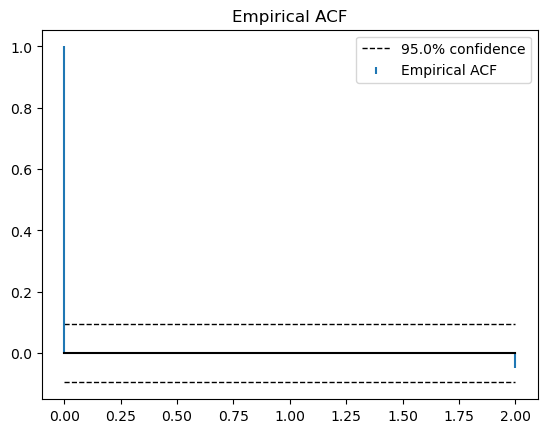

In [25]:
#Plotting ACF
acfplot(x=best_residuals_valid,lags=order_best_model,conf=0.95)

#### Observation:
From the plot we can see that all the coefficients work together to capture the data's behavior. Importantly, the autocorrelation values for these coefficients stayed within a range that is considered statistically significant (95% confidence interval). This indicates that the chosen model order of 118 provides a well-rounded fit to the data, with no one coefficient having a significantly greater impact than the others.

The model with order 10 emphasizes the importance of the first coefficient, while the model with order 118 distributes the influence more evenly among the coefficients, resulting in a well-fitting model that captures the data's temporal dependencies without any single coefficient dominating the explanation.


## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [26]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    

    for i in range(m):
        y_sim[i] = np.dot(phi, theta)  # <COMPLETE THIS LINE>
        # <COMPLETE THIS CODE BLOCK>
        phi = np.append(y_sim[i],phi[:-1])
            
    return y_sim
    

In [27]:
y = np.array(train["GMSL"])

# Predict the values for the validation data using the simulate_ar function
simulations = simulate_ar(y, theta=best_ar_coeff, m=len(valid))

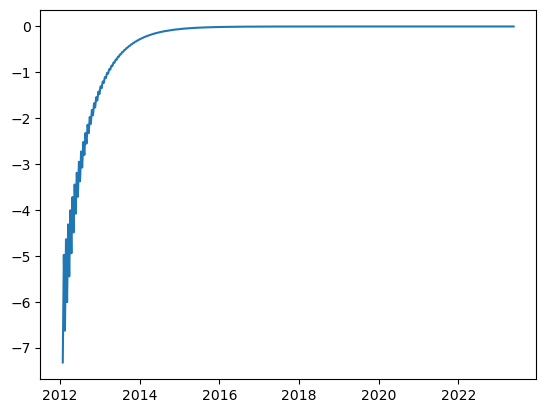

In [28]:
plt.plot(valid["Year"],simulations)
plt.show()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

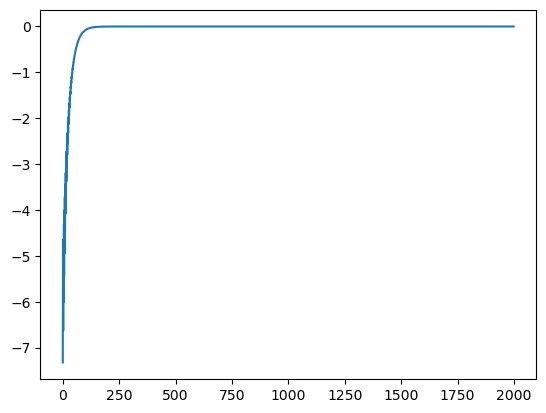

In [29]:
simulation_large = simulate_ar(y,theta=best_ar_coeff, m=2000)
plt.plot(simulation_large)
plt.show()

#### Observation:
The simulated values grow rapidly when we predict far into the future due to how autoregressive models work. In these models, each new prediction depends on past ones, and errors in predictions add up over time. If there is a small mistake in one prediction, it gets bigger in the next step, and this keeps compounding, leading to exponential growth. 

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [30]:
## Training NAR model 

y = train['GMSL'].values
# Number of training data points
n = len(y) 
p = order_best_model   
# Construct the regression matrix
Phi = np.zeros((n-p,p))  
for j in range(p):
    Phi[:,j] = y[j:n-p+j] 
    
# Drop the first p values from the target vector y
yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

#fitting non-linear AR model
regr = MLPRegressor(hidden_layer_sizes=10).fit(Phi,yy)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
## predictions and residuals

train_predict = regr.predict(Phi)
train_residuals = y[p:] -train_predict

y_valid = valid['GMSL'].values

# Number of training data points
n = len(y_valid) 

p = order_best_model  

# Construct the regression matrix for valid data
Phi_valid = np.zeros((n-p,p))  
for j in range(p):
    Phi_valid[:,j] = y_valid[j:n-p+j] 
    
valid_predict = regr.predict(Phi_valid)
valid_residuals = y_valid[p:] - valid_predict

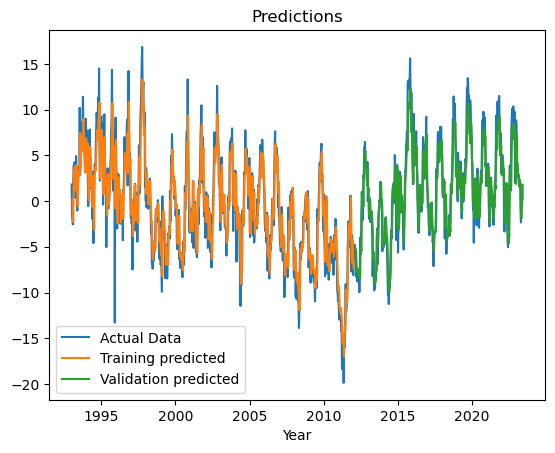

In [32]:
plt.plot(new_data["Year"], new_data["GMSL"], label="Actual Data")
plt.plot(train["Year"][p:],train_predict, label="Training predicted")
plt.plot(valid["Year"][p:],valid_predict, label="Validation predicted")
plt.title("Predictions")
plt.xlabel("Year")
plt.legend()
plt.show()

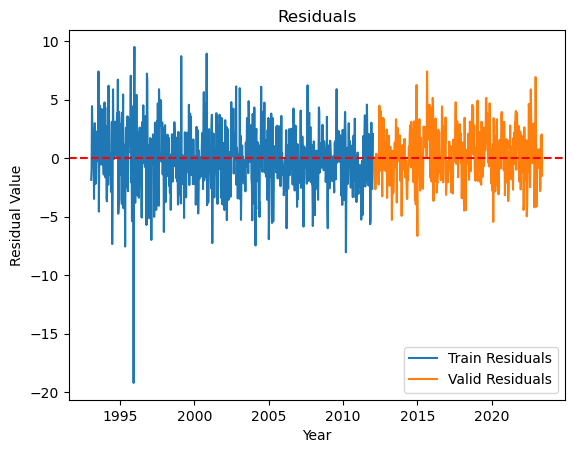

In [33]:
# plotting residuals
plt.plot(train["Year"].values[p:], train_residuals, label="Train Residuals")
plt.plot(valid["Year"].values[p:], valid_residuals, label="Valid Residuals")
plt.title("Residuals")
plt.xlabel("Year")
plt.ylabel("Residual Value")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**
We have experimented with different choices of hyperparamers. We are somewhat happy with the results we've achieved using the hyperparameters we chose. They've given us a training error of 4.202117 and a validation error of 4.439683, which means our model is doing a decent job at understanding patterns in the data. While these results are okay, there's a possibility that we can improve them even further with different hyperparameter choices. Even though these results are promising, we should always keep in mind that there's room for improvement. Balancing the complexity of our model with its performance is a continuous process.

In [34]:
# Experiment with different hidden layer sizes

hidden_layer_sizes_values = [10,20,30,40,50]

# Initializing lists to store MSE values for different hidden_layer_sizes
train_mse = []
valid_mse = []

np.random.seed(123)

# Iterate over the values of hidden_layer_sizes
for hidden_layer_size in hidden_layer_sizes_values:
    
    regr = MLPRegressor(hidden_layer_sizes=hidden_layer_size).fit(Phi,yy)
           
    pred_train = regr.predict(Phi) 
    pred_valid = regr.predict(Phi_valid)  
    
    # Calculate the MSE
    mse_train = np.mean(((pred_train - train["GMSL"][p:]) ** 2))
    mse_valid = np.mean(((pred_valid - valid["GMSL"][p:]) ** 2))
    
    train_mse.append(mse_train)
    valid_mse.append(mse_valid)
    
result = pd.DataFrame({'hidden_layers': hidden_layer_sizes_values, 'train_mse':train_mse, 'valid_mse':valid_mse} )   

# Printing MSE values for different hidden_layer_sizes
print(result.to_string(index=False))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


 hidden_layers  train_mse  valid_mse
            10   7.988685   5.214189
            20   7.688245   5.047287
            30   7.767257   5.035586
            40   7.705151   4.921330
            50   7.705082   4.981719


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
best_layers =result["hidden_layers"][result["valid_mse"]==np.min(result["valid_mse"])].values
print("Best number of hidden layers: ", best_layers[0])

Best number of hidden layers:  40


In [36]:
# Experiment with different activation functions

activations = ['identity', 'tanh', 'relu']

# Initializing lists to store MSE values for different activation functions
train_mse = []
valid_mse = []

np.random.seed(123)

# Iterate over different activations
for act in activations:
    
    regr = MLPRegressor(hidden_layer_sizes=30, activation=act).fit(Phi,yy)
           
    pred_train = regr.predict(Phi) 
    pred_valid = regr.predict(Phi_valid)  
    
    # Calculate the MSE
    mse_train = np.mean(((pred_train - train["GMSL"][p:]) ** 2))
    mse_valid = np.mean(((pred_valid - valid["GMSL"][p:]) ** 2))
    
    train_mse.append(mse_train)
    valid_mse.append(mse_valid)
    
result = pd.DataFrame({'Activation': activations, 'train_mse':train_mse, 'valid_mse':valid_mse} )   

# Printing MSE values for different activation functions
print(result.to_string(index=False))

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation  train_mse  valid_mse
  identity   7.871574   4.924188
      tanh   8.496665   5.364709
      relu   7.655277   5.025029


C:\Users\Dell\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [37]:
best_activation =result["Activation"][result["valid_mse"]==np.min(result["valid_mse"])].values
print("Best activation function: ", best_activation[0])

Best activation function:  identity


In [38]:
# Experiment with different solvers

solvers = ['lbfgs', 'sgd', 'adam']

# Initializing lists to store MSE values for different solvers
train_mse = []
valid_mse = []

np.random.seed(123)

# Iterate over different solvers
for sol in solvers:
    
    regr = MLPRegressor(hidden_layer_sizes=30, activation='identity',solver=sol).fit(Phi,yy)
           
    pred_train = regr.predict(Phi) 
    pred_valid = regr.predict(Phi_valid)  
    
    # Calculate the MSE
    mse_train = np.mean(((pred_train - train["GMSL"][p:]) ** 2))
    mse_valid = np.mean(((pred_valid - valid["GMSL"][p:]) ** 2))
    
    train_mse.append(mse_train)
    valid_mse.append(mse_valid)
    
result = pd.DataFrame({'Solver': solvers, 'train_mse':train_mse, 'valid_mse':valid_mse} )   

# Printing MSE values for different solvers
print(result.to_string(index=False))

Solver  train_mse  valid_mse
 lbfgs   7.871352   4.930369
   sgd   7.872829   4.933721
  adam   7.872145   4.955752


In [39]:
best_solver =result["Solver"][result["valid_mse"]==np.min(result["valid_mse"])].values
print("Best solver: ", best_solver[0])

Best solver:  lbfgs


In [40]:
# Experiment with different values of max_iter

max_iters = [100, 200, 300, 400, 500,600]

# Initializing lists to store MSE values for different values of max_iter
train_mse = []
valid_mse = []

np.random.seed(123)

# Iterate over different values of max_iter
for itr in max_iters:
    
    regr = MLPRegressor(hidden_layer_sizes=30, activation='identity',solver='lbfgs', max_iter=itr).fit(Phi,yy)
           
    pred_train = regr.predict(Phi) 
    pred_valid = regr.predict(Phi_valid)  
    
    # Calculate the MSE
    mse_train = np.mean(((pred_train - train["GMSL"][p:]) ** 2))
    mse_valid = np.mean(((pred_valid - valid["GMSL"][p:]) ** 2))
    
    train_mse.append(mse_train)
    valid_mse.append(mse_valid)
    
result = pd.DataFrame({'max_iter': max_iters, 'train_mse':train_mse, 'valid_mse':valid_mse} )   

# Printing MSE values for different values of max_iter
print(result.to_string(index=False))

 max_iter  train_mse  valid_mse
      100   7.871352   4.930369
      200   7.871352   4.930359
      300   7.871352   4.930350
      400   7.871352   4.930365
      500   7.871352   4.930421
      600   7.871352   4.930382


In [41]:
best_max_itr =result["max_iter"][result["valid_mse"]==np.min(result["valid_mse"])].values
print("Best max_iter: ", best_max_itr[0])

Best max_iter:  300
